In [1]:
import sys
sys.path.append('../../Dataset-Management-Library/mimic3wfdb')
import wfdb
import asyncio
import numpy as np
import pandas as pd
import wfdb_util as wu
import matplotlib.pyplot as plt

In [2]:
def get_stats(df):
    total = len(df)
    num_female = len(df.loc[df['gender']=='F'])
    num_male = len(df.loc[df['gender']=='M'])
    mean_age = df['age'].mean(); std_age = df['age'].std()
    mean_wg = df['weight_kg'].mean(); std_wg = df['weight_kg'].std()
    mean_ht_inch = df['height_inches'].mean(); std_ht_inch = df['height_inches'].std()
    mean_ht_cm = df['height_cm'].mean(); std_ht_cm = df['height_cm'].std()
    mean_bmi = df['bmi'].mean(); std_bmi = df['bmi'].std()

    return total, (num_male, num_female), (mean_age, std_age), (mean_wg, std_wg), (mean_ht_inch, std_ht_inch), (mean_ht_cm, std_ht_cm), (mean_bmi, std_bmi)

In [3]:
dataset = pd.read_parquet('../dataset/2312260100_intersectDemoWave.parquet.gzip')

## Get Record of Interest

In [4]:
# PLETH, ABP 둘 다 가진 record만 가져오기
record_of_interest = []
for rec in dataset.record_name.values:
    record_name, _, _, _, _, elements = await wu.async_get_field('../../DataLake/mimic-iii_wfdb/', rec)
    if all(item in elements for item in ['PLETH', 'ABP']):
        record_of_interest.append(record_name)

record_of_interest = np.array(record_of_interest)
# duration: 25.4s

In [6]:
dataset = dataset.query(f'record_name.isin({list(record_of_interest)})').reset_index(drop=True)
display(dataset.head())
print(dataset.shape)

,subject_id,gender,age,admittime,dischtime,weight_kg,height_inches,height_cm,bmi,subdir,record_name,recordtime
0,160,F,50,2174-11-06 08:38:00,2174-11-08 16:35:00,58.599998,67.0,170.199997,20.200001,p00,p000160-2174-11-06-10-12.hea,2174-11-06 10:12:00
1,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-02-19-15-13.hea,2109-02-19 15:13:00
2,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-03-07-14-25.hea,2109-03-07 14:25:00
3,773,M,58,2109-02-18 06:04:00,2109-03-17 20:25:00,106.900002,75.0,190.500000,29.500000,p00,p000773-2109-03-11-15-03.hea,2109-03-11 15:03:00
4,801,F,46,2197-06-19 19:47:00,2197-08-03 13:00:00,78.500000,66.0,167.600006,27.900000,p00,p000801-2197-07-02-01-18.hea,2197-07-02 01:18:00


(285, 12)


In [7]:
dataset.to_parquet('../dataset/2312260200_interestDemoWave.parquet.gzip', engine='pyarrow', compression='gzip')

## Clean outliers

In [8]:
total, gender, age, weight, ht_inch, ht_cm, bmi = get_stats(dataset)

org_mimic_stat = pd.DataFrame({
    'Total': [f'{total}'], 
    'Males': [f'{gender[0]} ({gender[0]/total*100:.1f}%)'], 
    'Females': [f'{gender[1]} ({gender[1]/total*100:.1f}%)'],
    'Age': [f'{age[0]:.1f} ± {age[1]:.1f}'],
    'Weight(kg)': [f'{weight[0]:.1f} ± {weight[1]:.1f}'],
    'Height(inch)': [f'{ht_inch[0]:.1f} ± {ht_inch[1]:.1f}'],
    'Height(cm)': [f'{ht_cm[0]:.1f} ± {ht_cm[1]:.1f}'],
    'Body Mass Index(kg/m2)': [f'{bmi[0]:.1f} ± {bmi[1]:.1f}'],
    })

org_mimic_stat

,Total,Males,Females,Age,Weight(kg),Height(inch),Height(cm),Body Mass Index(kg/m2)
0,285,189 (66.3%),96 (33.7%),65.1 ± 14.7,87.6 ± 27.0,66.7 ± 5.8,169.5 ± 14.6,47.0 ± 282.6


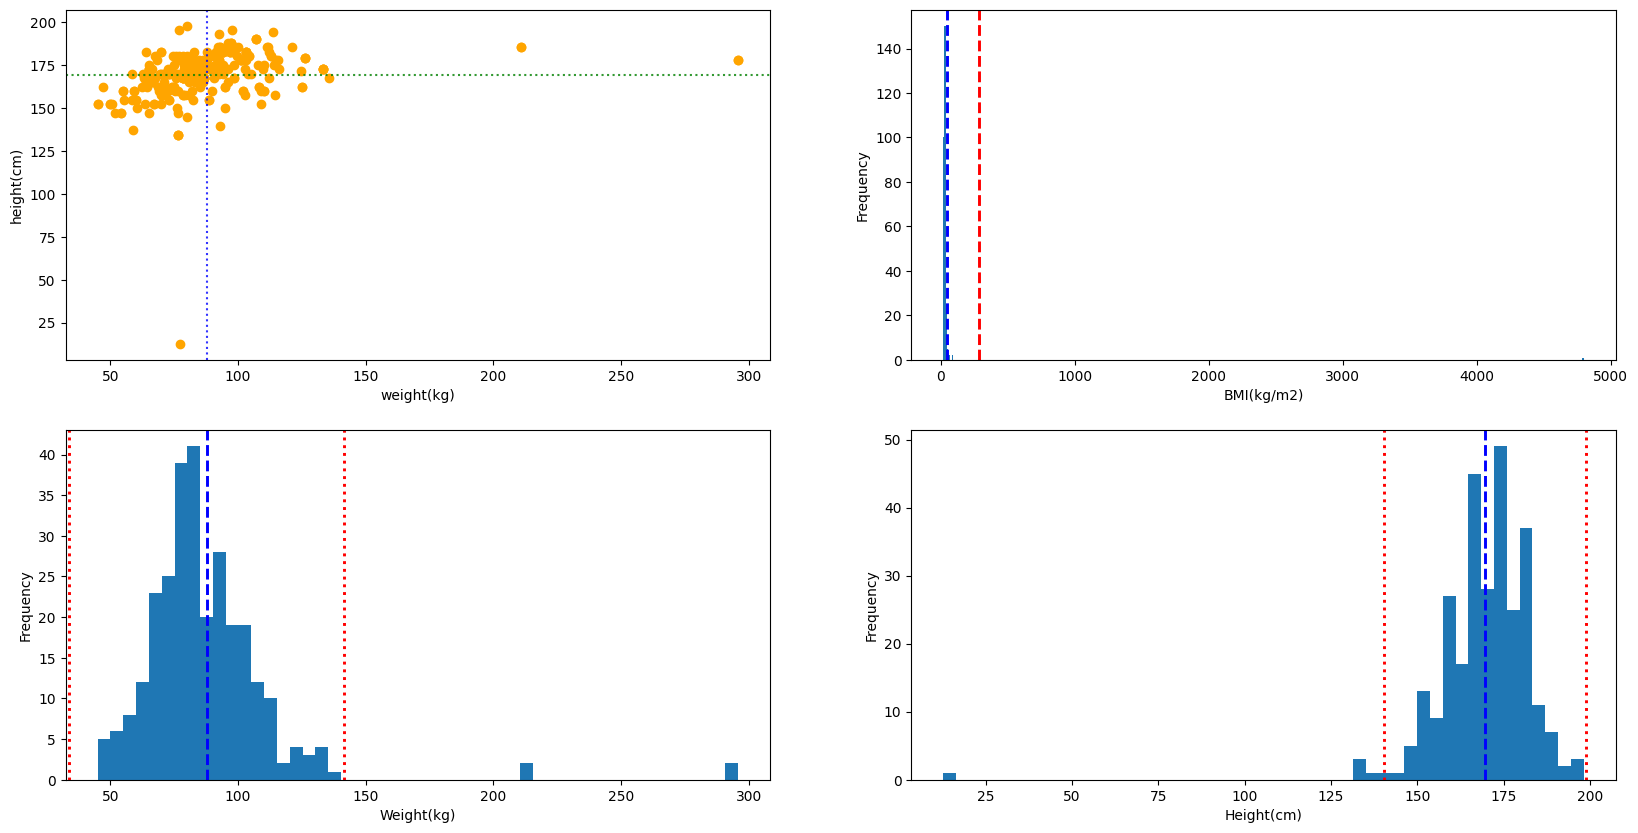

In [9]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].scatter(dataset.weight_kg, dataset.height_cm, alpha=1, c='orange')
axs[0][0].axvline(weight[0], linestyle=':', c='b', alpha=.8)
axs[0][0].axhline(ht_cm[0], linestyle=':', c='g', alpha=.8)
axs[0][0].set_xlabel('weight(kg)')
axs[0][0].set_ylabel('height(cm)')

axs[0][1].hist(dataset.bmi, bins=500)
axs[0][1].axvline(bmi[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
axs[0][1].axvline(bmi[1], linestyle='--', linewidth=2.1, c='red', alpha=1)
axs[0][1].set_xlabel('BMI(kg/m2)')
axs[0][1].set_ylabel('Frequency')

axs[1][0].hist(dataset.weight_kg, bins=50)
axs[1][0].axvline(weight[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
axs[1][0].axvline(weight[0] + 2*weight[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][0].axvline(weight[0] - 2*weight[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][0].set_xlabel('Weight(kg)')
axs[1][0].set_ylabel('Frequency')

axs[1][1].hist(dataset.height_cm, bins=50)
axs[1][1].axvline(ht_cm[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
axs[1][1].axvline(ht_cm[0] + 2*ht_cm[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][1].axvline(ht_cm[0] - 2*ht_cm[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][1].set_xlabel('Height(cm)')
axs[1][1].set_ylabel('Frequency')
plt.show()

In [10]:
dataset['z_weight'] = (dataset['weight_kg'] - weight[0])/weight[1]
dataset['z_height'] = (dataset['height_cm'] - ht_cm[0])/ht_cm[1]
dataset['z_bmi'] = (dataset['bmi'] - bmi[0])/bmi[1]

In [11]:
outliers = np.concatenate([dataset.loc[(dataset['z_weight'] >= 2)|(dataset['z_weight'] <= -2)].index.values, dataset.loc[(dataset['z_height'] >= 2)|(dataset['z_height'] <= -2)].index.values])
cln_mimic_df = dataset.drop(index=outliers)

In [12]:
total, gender, age, weight, ht_inch, ht_cm, bmi = get_stats(cln_mimic_df)

cln_mimic_stat = pd.DataFrame({
    'Total': [f'{total}'], 
    'Males': [f'{gender[0]} ({gender[0]/total*100:.1f}%)'], 
    'Females': [f'{gender[1]} ({gender[1]/total*100:.1f}%)'],
    'Age': [f'{age[0]:.1f} ± {age[1]:.1f}'],
    'Weight(kg)': [f'{weight[0]:.1f} ± {weight[1]:.1f}'],
    'Height(inch)': [f'{ht_inch[0]:.1f} ± {ht_inch[1]:.1f}'],
    'Height(cm)': [f'{ht_cm[0]:.1f} ± {ht_cm[1]:.1f}'],
    'Body Mass Index(kg/m2)': [f'{bmi[0]:.1f} ± {bmi[1]:.1f}'],
    })

cln_mimic_stat

,Total,Males,Females,Age,Weight(kg),Height(inch),Height(cm),Body Mass Index(kg/m2)
0,275,182 (66.2%),93 (33.8%),65.4 ± 14.2,85.5 ± 17.8,67.1 ± 4.1,170.5 ± 10.4,29.4 ± 5.7


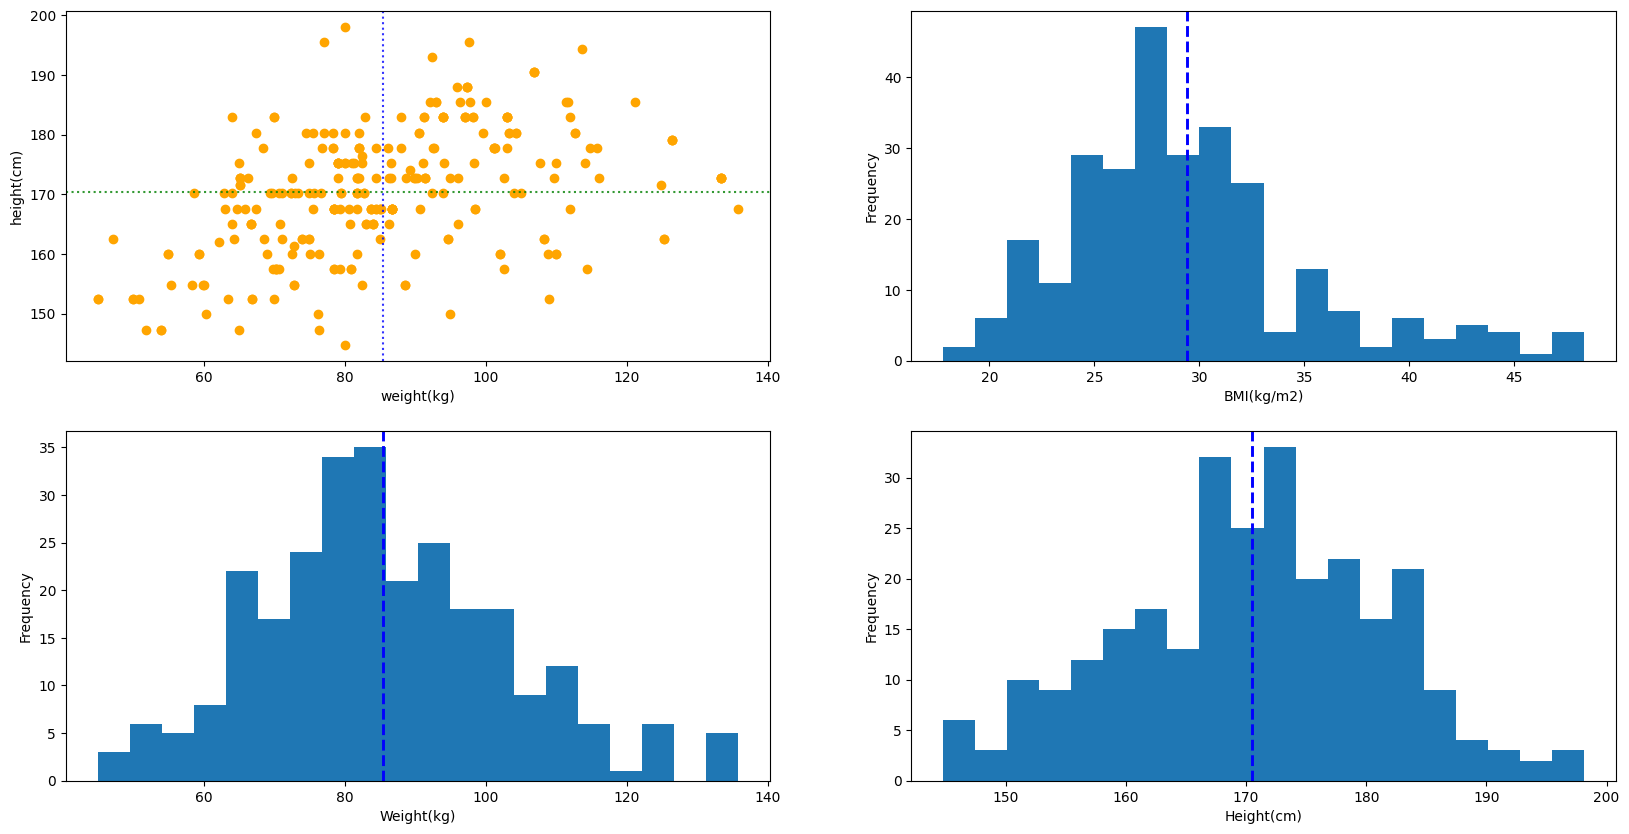

In [13]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
axs[0][0].scatter(cln_mimic_df.weight_kg, cln_mimic_df.height_cm, alpha=1, c='orange')
axs[0][0].axvline(weight[0], linestyle=':', c='b', alpha=.8)
axs[0][0].axhline(ht_cm[0], linestyle=':', c='g', alpha=.8)
axs[0][0].set_xlabel('weight(kg)')
axs[0][0].set_ylabel('height(cm)')

axs[0][1].hist(cln_mimic_df.bmi, bins=20)
axs[0][1].axvline(bmi[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
# axs[0][1].axvline(bmi[0]+2*bmi[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
# axs[0][1].axvline(bmi[0]-2*bmi[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[0][1].set_xlabel('BMI(kg/m2)')
axs[0][1].set_ylabel('Frequency')

axs[1][0].hist(cln_mimic_df.weight_kg, bins=20)
axs[1][0].axvline(weight[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
# axs[1][0].axvline(weight[0]+2*weight[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
# axs[1][0].axvline(weight[0]-2*weight[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][0].set_xlabel('Weight(kg)')
axs[1][0].set_ylabel('Frequency')

axs[1][1].hist(cln_mimic_df.height_cm, bins=20)
axs[1][1].axvline(ht_cm[0], linestyle='--', linewidth=2.1, c='blue', alpha=1)
# axs[1][1].axvline(ht_cm[0]+2*ht_cm[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
# axs[1][1].axvline(ht_cm[0]-2*ht_cm[1], linestyle=':', linewidth=2.1, c='red', alpha=1)
axs[1][1].set_xlabel('Height(cm)')
axs[1][1].set_ylabel('Frequency')
plt.show()

In [14]:
cln_mimic_df.to_parquet('../dataset/2312260201_cleanDemoWave.parquet.gzip', engine='pyarrow', compression='gzip')

## Get sample

In [4]:
cln_mimic_df = pd.read_parquet('../dataset/2312260201_cleanDemoWave.parquet.gzip')

In [32]:
signals, rec_names = await wu.async_get_samples('../../DataLake/mimic-iii_wfdb/', cln_mimic_df.record_name.values, sampfrom=0, sampto=125*60*10, channel_names=['PLETH', 'ABP'])
# duration: 11.3s

/root/Workspace/231113-CBTP-PPG/evaluate-BP/../../Dataset-Management-Library/mimic3wfdb/wfdb_util.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rec_names = np.array(list(filter(lambda x: x[0] is not None, results)))[:, 1]


In [33]:
results = np.concatenate((np.repeat(rec_names, 75000).reshape(266,75000,1), signals), axis=2)
results.shape

(266, 75000, 3)

In [34]:
# 총 285개 샘플 중 266개 샘플
np.save('../dataset/2312260202_dataset.npy', results)